In [85]:
import bioread
import numpy as np
import pandas as pd
import heartpy as hp
import neurokit2 as nk

acq_file = bioread.read_file(r'C:\Users\User\Downloads\80_28.1.24 (NPU_template).acq')

channels_to_extract = ['ECG - ECG100C', 'C5 - Expression' ]
data = {}
for channel_name in channels_to_extract:
    channel = acq_file.named_channels[channel_name]
    data[channel_name] = channel.data

df = pd.DataFrame(data)
print(df)


         ECG - ECG100C  C5 - Expression
0             0.000000              0.0
1             0.000153              0.0
2            -0.000153              0.0
3             0.000000              0.0
4             0.000000              0.0
...                ...              ...
3132788      -0.097656              0.0
3132789      -0.100098              0.0
3132790      -0.102539              0.0
3132791      -0.105438              0.0
3132792      -0.109253              0.0

[3132793 rows x 2 columns]


In [86]:
df = df.dropna()
df = df.reset_index(drop=True)


In [87]:
non_zero_indices = df.index[df['C5 - Expression'] != 0]
index_rows_to_change = []
for i in range(len(non_zero_indices)-1):
    if non_zero_indices[i+1] == non_zero_indices[i]+1:
        index_rows_to_change.append(non_zero_indices[i])
for index in index_rows_to_change:
    df.loc[index, 'C5 - Expression'] = 0

In [88]:
print(df)

         ECG - ECG100C  C5 - Expression
0             0.000000              0.0
1             0.000153              0.0
2            -0.000153              0.0
3             0.000000              0.0
4             0.000000              0.0
...                ...              ...
3132788      -0.097656              0.0
3132789      -0.100098              0.0
3132790      -0.102539              0.0
3132791      -0.105438              0.0
3132792      -0.109253              0.0

[3132793 rows x 2 columns]


In [89]:
df_baseline = df['ECG - ECG100C'][df['C5 - Expression']==99]

print(df_baseline)

481122    0.016327
Name: ECG - ECG100C, dtype: float64


In [90]:
df_baseline_minute = pd.DataFrame()
for index in df_baseline.index:
    df_slice = df['ECG - ECG100C'].iloc[index : index + 2000 * 60]
    df_slice = df_slice.to_frame(name='ECG - ECG100C')
    df_baseline_minute = pd.concat([df_baseline_minute, df_slice])
print(df_baseline_minute)

        ECG - ECG100C
481122       0.016327
481123       0.016632
481124       0.017548
481125       0.017548
481126       0.018463
...               ...
601117      -0.069733
601118      -0.070953
601119      -0.071259
601120      -0.072021
601121      -0.072632

[120000 rows x 1 columns]


In [91]:
baseline_minute_array = df_baseline_minute['ECG - ECG100C'].values.flatten()
print(baseline_minute_array)

[ 0.0163269   0.01663208  0.01754761 ... -0.07125854 -0.07202148
 -0.07263184]


In [92]:

signals, info = nk.ecg_process(baseline_minute_array, 2000)
print(signals)
heart_rate = signals['ECG_Rate']
print(heart_rate)

         ECG_Raw  ECG_Clean   ECG_Rate  ECG_Quality  ECG_R_Peaks  ECG_P_Peaks  \
0       0.016327   0.000721  53.073401     0.881548            0            0   
1       0.016632   0.001131  53.073401     0.881548            0            0   
2       0.017548   0.001542  53.073401     0.881548            0            0   
3       0.017548   0.001951  53.073401     0.881548            0            0   
4       0.018463   0.002359  53.073401     0.881548            0            0   
...          ...        ...        ...          ...          ...          ...   
119995 -0.069733   0.019685  46.893318     0.000000            0            0   
119996 -0.070953   0.019029  46.893318     0.000000            0            0   
119997 -0.071259   0.018369  46.893318     0.000000            0            0   
119998 -0.072021   0.017706  46.893318     0.000000            0            0   
119999 -0.072632   0.017043  46.893318     0.000000            0            0   

        ECG_P_Onsets  ECG_P

c:\users\user\appdata\local\programs\python\python38\lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:474: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(


    HRV_MeanNN   HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  HRV_SDANN2  HRV_SDNNI2  \
0  1130.509804  96.541933         NaN         NaN         NaN         NaN   

   HRV_SDANN5  HRV_SDNNI5   HRV_RMSSD   HRV_SDSD  ...  HRV_SampEn  HRV_ShanEn  \
0         NaN         NaN  104.248261  105.27389  ...    2.890372     5.63321   

   HRV_FuzzyEn  HRV_MSEn  HRV_CMSEn  HRV_RCMSEn    HRV_CD   HRV_HFD   HRV_KFD  \
0     1.456398       0.0        0.0         0.0  2.180887  1.868748  3.393007   

    HRV_LZC  
0  1.001016  

[1 rows x 82 columns]


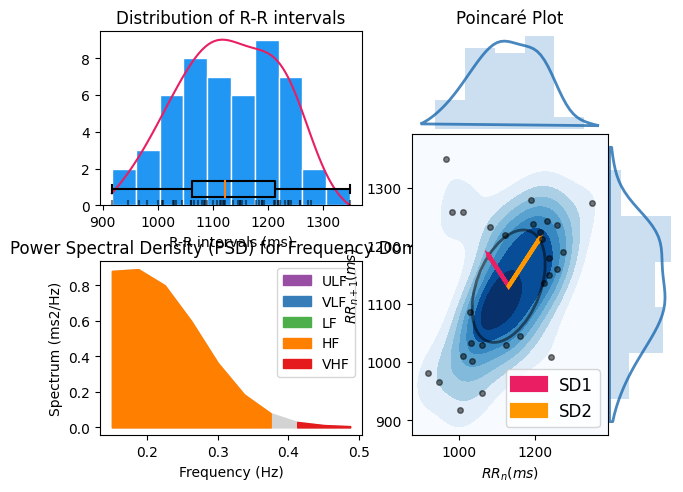

In [93]:
rPeaks = info['ECG_R_Peaks']
hrv_metrics = nk.hrv(rPeaks, sampling_rate=2000, show=True)
print(hrv_metrics)

In [96]:
ecg_data =  {
    "n_cue": [],
    "n_no_cue": [],
    "p_cue": [],
    "p_no_cue": [],
    "u_cue": [],
    "u_no_cue": []
}
for index, row in df.iterrows():
    value = row['C5 - Expression']
    ecg_value = row['ECG - ECG100C']
    
    
    if value == 020.0:
        ecg_data["n_cue"].append(ecg_value)
    if value == 030.0:
        ecg_data["n_no_cue"].append(ecg_value)
    if value == 120.0:
        ecg_data["p_cue"].append(ecg_value)
    if value == 130.0:
        ecg_data["p_no_cue"].append(ecg_value)
    if value == 220.0:
        ecg_data["u_cue"].append(ecg_value)
    if value == 230.0:
        ecg_data["u_no_cue"].append(ecg_value)
        
max_length = max(len(ecg_data[key]) for key in ecg_data)
for key in ecg_data:
    while len(ecg_data[key]) < max_length:
        ecg_data[key].append(None)
df_ecg = pd.DataFrame(ecg_data)
print(df_ecg)


    
         


       n_cue  n_no_cue     p_cue  p_no_cue     u_cue  u_no_cue
0  -0.048065 -0.008698 -0.004578  0.016174  0.102844 -0.026703
1  -0.019684  0.130157 -0.006866 -0.040588  0.067291 -0.094452
2  -0.026398 -0.010529  0.030975 -0.038300 -0.004425 -0.044556
3  -0.152893  0.074768 -0.047150 -0.041046 -0.025482 -0.048828
4  -0.028381  1.200714  0.029297 -0.042725 -0.053406  0.059814
5  -0.014648 -0.022430 -0.019989 -0.561829 -0.009155  0.146790
6   0.114136  0.104828       NaN -0.021210       NaN -0.041046
7  -0.020294  0.016479       NaN -0.087585       NaN -0.053253
8  -0.012054 -0.007782       NaN       NaN       NaN       NaN
9        NaN -0.016785       NaN       NaN       NaN       NaN
10       NaN  0.139313       NaN       NaN       NaN       NaN
11       NaN  0.013428       NaN       NaN       NaN       NaN


In [ ]:


## trying with neurokit   
ecg_sampling_rate = 2000
heart_rate_data = {}
for column in df_ecg.columns:
    signals = nk.ecg_process(df_ecg[column], ecg_sampling_rate)
    heart_rate = nk.ecg_rate(signals)
    heart_rate_data[column] = heart_rate
print("Heart Rates:")
for column, heart_rate in heart_rate_data.items():
    print(f"{column}: {heart_rate.mean()} bpm")

heart_rate_df = pd.DataFrame(heart_rate_data)

mean_heart_rate_per_column = heart_rate_df.mean(axis=0)

print("Mean Heart Rate per column:")
print(mean_heart_rate_per_column)
    
    







    